In [1]:
import sconce
print(f"Notebook run using pytorch-sconce {sconce.__version__}")

Notebook run using pytorch-sconce 1.3.0


/home/davidmorton/git_repos/simpsons-character-identification/.tox/jupyter/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
from sconce.data_feeds import SingleClassImageFeed
from sconce.datasets import Subset
from torchvision import datasets, transforms

import numpy as np
import random

## Creating the Training and Validation Data Feeds

In [3]:
split_factor = 0.80
root = 'data/common_characters'
image_size = 48

def one_of_five(image_size):
    def fn(image_input):
        five_crops = transforms.FiveCrop(image_size)(image_input)
        return random.choice(five_crops)
    return fn
    
training_transform = transforms.Compose([
    transforms.Resize(int(image_size*1.5)),
    one_of_five(int(image_size) * 1.15),
    transforms.RandomAffine(degrees=(0,10),
                            translate=(0.02, 0.02),
                            scale=(1.0, 1.1)),
    transforms.RandomHorizontalFlip(),
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.0], std=[1.0])
])

validation_transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.0], std=[1.0])
])

base_feed = SingleClassImageFeed.from_image_folder(
        root=root, transform=training_transform)
training_feed, validation_feed = base_feed.split(split_factor,
        batch_size=100, num_workers=7, shuffle=True,
        validation_transform=validation_transform)

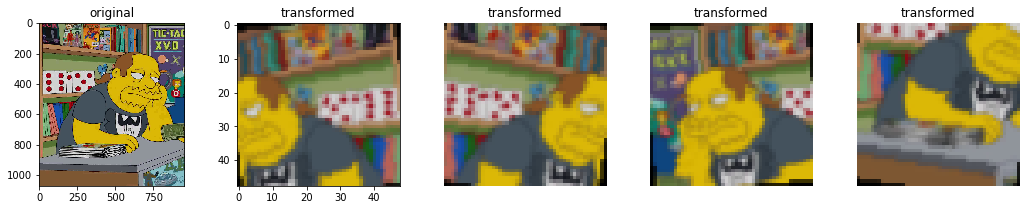

In [4]:
training_feed.plot_transforms(123)

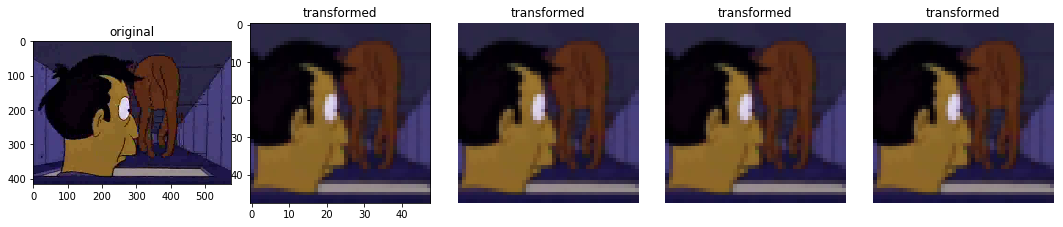

In [5]:
validation_feed.plot_transforms(126)

In [6]:
inputs, targets = training_feed.next()
inputs.shape, targets.shape

(torch.Size([100, 3, 48, 48]), torch.Size([100]))

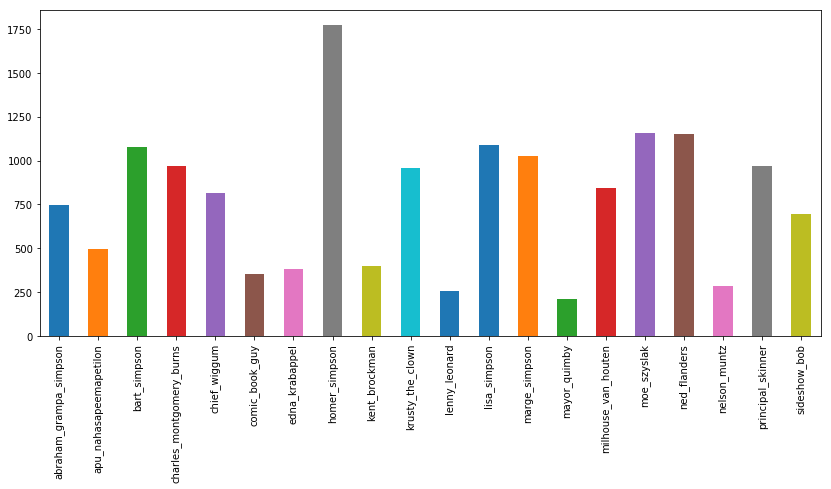

In [7]:
training_feed.plot_class_summary(figsize=(14,6))

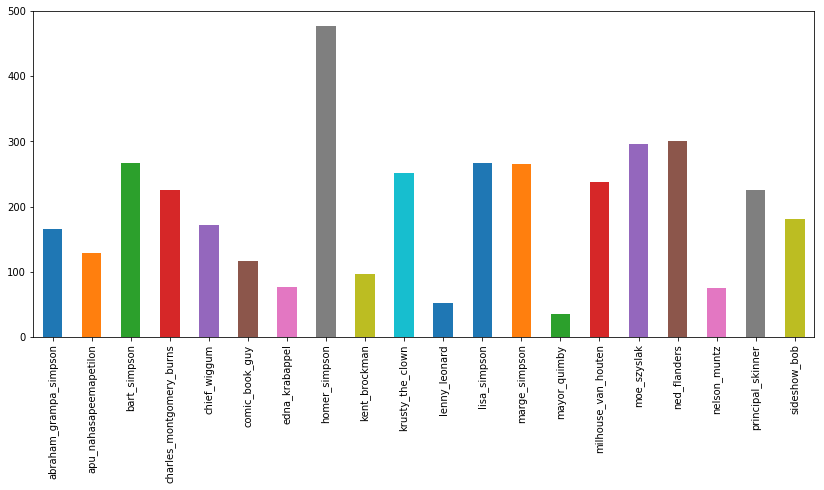

In [8]:
validation_feed.plot_class_summary(figsize=(14,6))

## Define the Model and construct the Trainer

In [9]:
from sconce.models import WideResnetImageClassifier

In [10]:
num_classes = len(training_feed.dataset.classes)
m = WideResnetImageClassifier(
        image_channels=3, depth=28,
        widening_factor=4, num_categories=num_classes)

In [11]:
from torch import optim

m.set_optimizer(optim.SGD, lr=0.1, momentum=0.9, weight_decay=5e-5)

In [12]:
import torch

if torch.cuda.is_available:
    m.cuda()
    training_feed.cuda()
    validation_feed.cuda()

In [13]:
from sconce.trainers import SingleClassImageClassifierTrainer

In [14]:
t = SingleClassImageClassifierTrainer(model=m,
                                      training_feed=training_feed,
                                      validation_feed=validation_feed)

## Survey the learning rate

63/63 [==============================] - 23s 369ms/step - loss: 3.0861


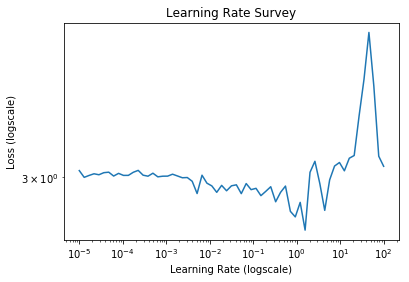

In [15]:
monitor = t.survey_learning_rate(num_epochs=0.4,
                                 min_learning_rate=1e-5,
                                 max_learning_rate=100,
                                 stop_factor=1.5)
monitor.dataframe_monitor.plot_learning_rate_survey()

## Train

In [16]:
from sconce.schedules import Triangle
m.set_schedule('learning_rate', Triangle(
        initial_value=1e-3, peak_value=5e-2))
m.set_schedule('momentum', Triangle(
        initial_value=0.98, peak_value=0.02))
t.train(num_epochs=40);

6256/6256 [==============================] - 2551s 408ms/step - loss: 0.3929 - val_loss: 0.2114


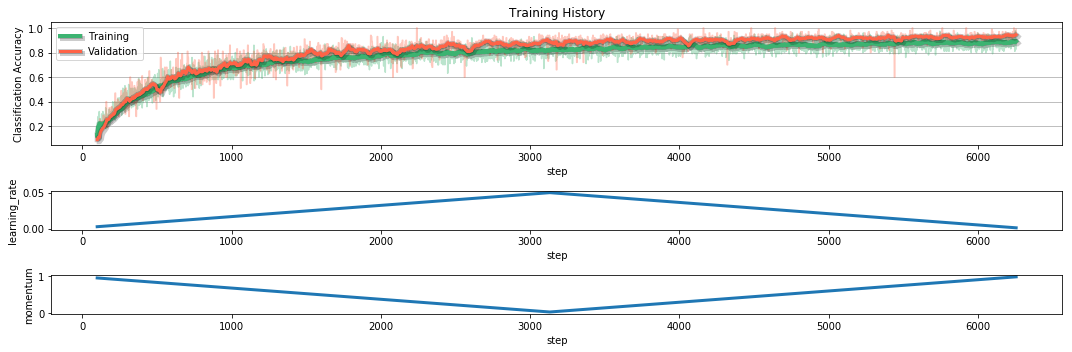

In [17]:
t.monitor.dataframe_monitor.plot(
        metrics=['classification_accuracy'],
        hyperparameters=['learning_rate', 'momentum'],
);

In [18]:
from sconce.schedules import Linear
m.set_schedule('learning_rate', Linear(initial_value=1e-3,
                                       final_value=0.0))
m.set_schedule('momentum', 0.98)
t.train(num_epochs=10)

1564/1564 [==============================] - 637s 408ms/step - loss: 0.2268 - val_loss: 0.1529


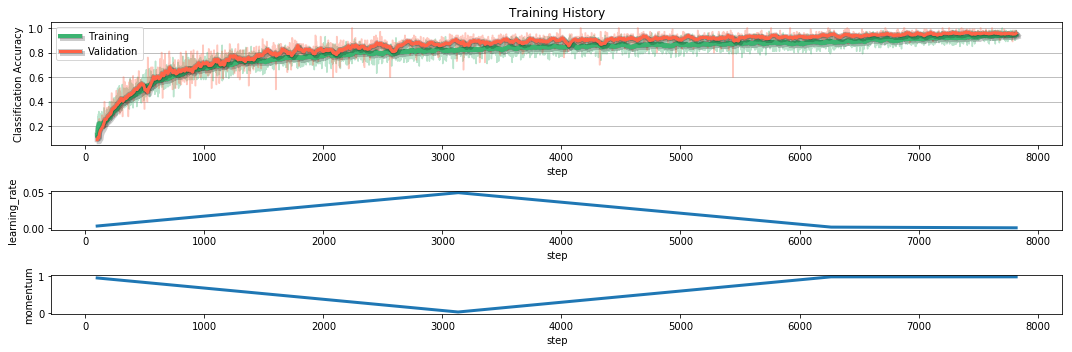

In [19]:
t.monitor.dataframe_monitor.plot(
        metrics=['classification_accuracy'],
        hyperparameters=['learning_rate', 'momentum'],
);

## Explore predictions of trained model

In [20]:
t.get_classification_accuracy()

0.9567774936061381

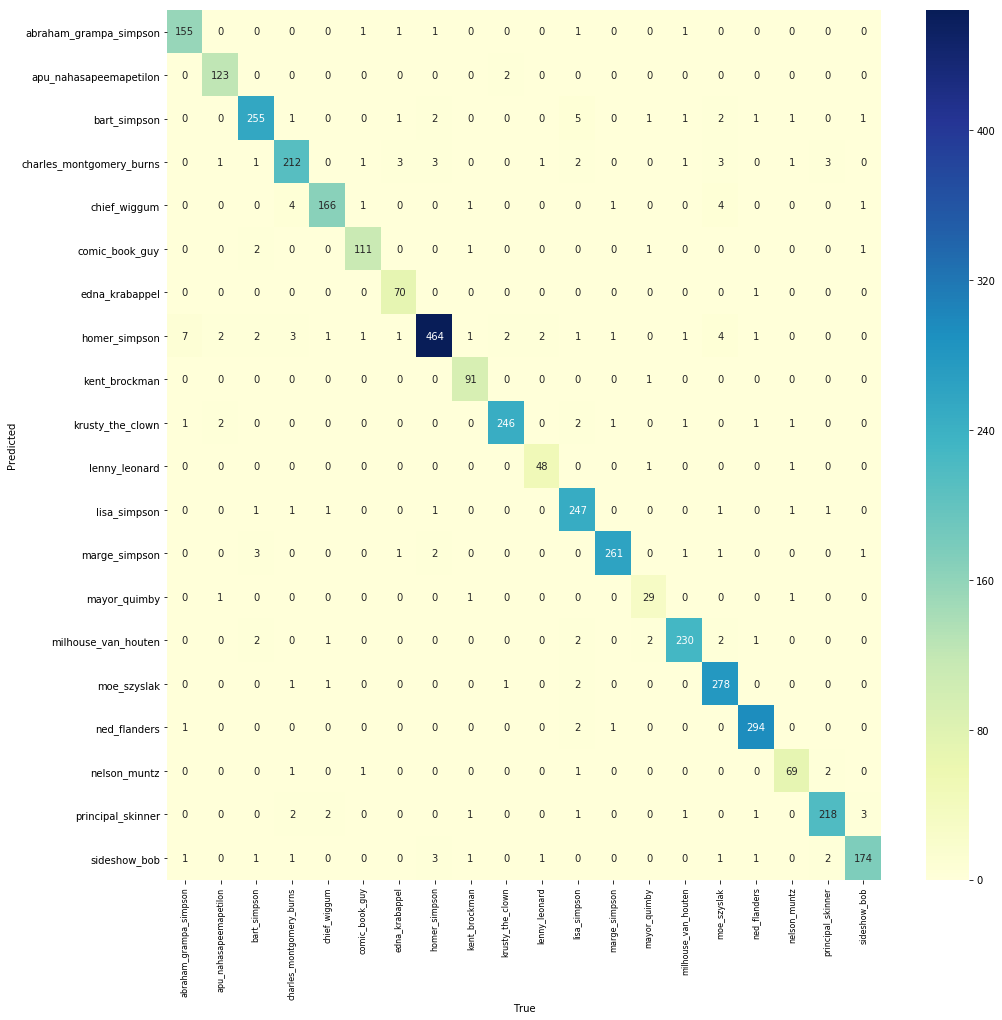

In [21]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize=(16, 16)) 
ax = t.plot_confusion_matrix(ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90, fontsize = 8);

Least sure, but correct predictions of Krusty the Clown
Showing only the first 20 of 246 images


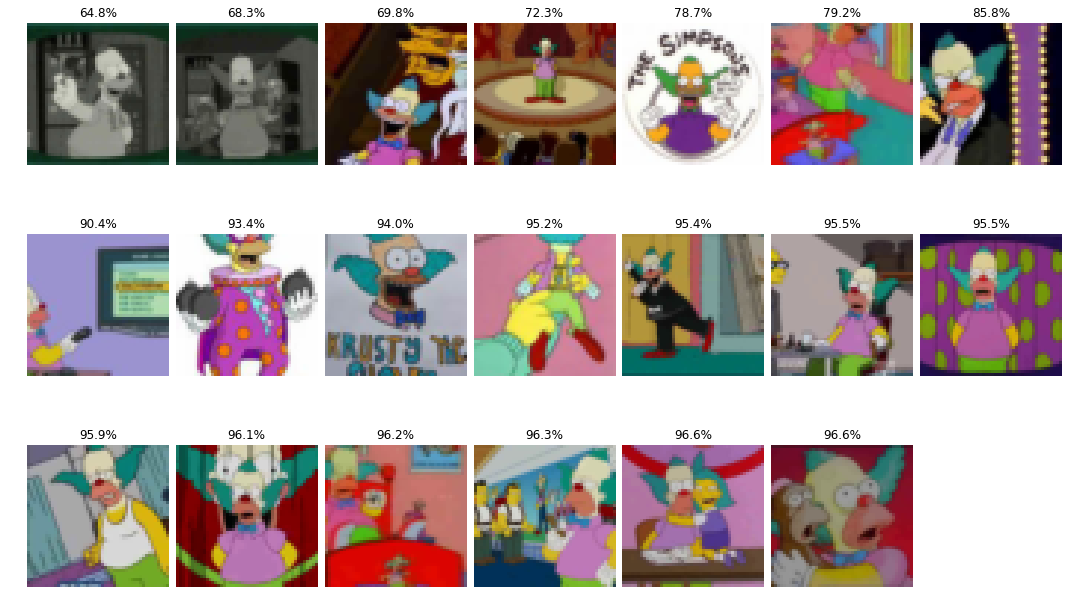

In [31]:
print("Least sure, but correct predictions of Krusty the Clown")
t.plot_samples(predicted_class='krusty_the_clown',
               true_class='krusty_the_clown',
               sort_by='rising predicted class score',
               num_samples=20,
);

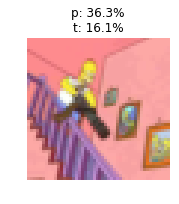

In [29]:
t.plot_samples(predicted_class='abraham_grampa_simpson',
               true_class='homer_simpson');

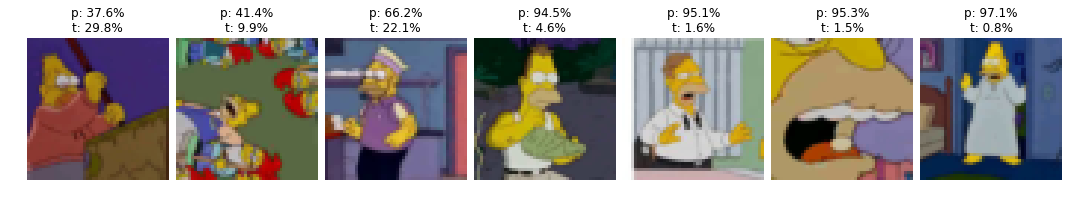

In [30]:
t.plot_samples(predicted_class='homer_simpson',
               true_class='abraham_grampa_simpson');